<a href="https://colab.research.google.com/github/alice9547/covid-19_model/blob/main/corona19_regional_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자치구별 코로나 확진자 예측

## [ 서울 열린 데이터 광장 ] 
### 서울특별시 코로나19 자치구별 확진자 발생동향 API
https://data.seoul.go.kr/dataList/OA-20470/S/1/datasetView.do

💡 본 프로그램은 https://github.com/kairess/corona-virus-prediction 의 응용임을 밝힙니다.

In [ ]:
# 필요 라이브러리 불러오기
import requests # API를 사용하기 위한 모듈
from bs4 import BeautifulSoup # 텍스트 형태의 HTML과 XML에서 데이터를 추출하기 위한 라이브러리
import pandas as pd # 텍스트 입출력 및 데이터프레임 가공이 가능 한 라이브러리

import plotly.graph_objs as go # 그래프 라이브러리
import plotly.offline as py
from fbprophet import Prophet # 시계열 예측 라이브러리
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import json, urllib.request
import requests
import csv

import numpy as np #행렬이나 다차원 배열을 처리할때 사용하는 라이브러리

#### 공공데이터 포털 API

In [ ]:
#ServiceKey = 'dypF53MOyB5SvOwH2UtPxnT4vEggzFRRQrSIAV%2BZW3%2FNurg6Mo4Zl5DxsNjqCDHxBVE5hcadyB1%2FxU92iwPtgA%3D%3D'
#url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson?serviceKey="
#api_url = url + ServiceKey

#### 서울데이터열린광장 API

In [ ]:
ServiceKey = '74766d63646e61793639476a424f51' # API 인증키
url = "http://openAPI.seoul.go.kr:8088/"+ ServiceKey + "/json/TbCorona19CountStatusJCG/1/550/"
# api_url의 "/xml/TbCorona19CountStatusJCG/1/5/"에서 '5'부분은 가져올 데이터 수. 조절하여 가져올 수 있다.

In [ ]:
data = urllib.request.urlopen(url).read()

#받아온 json 데이터 특정하기
output = json.loads(data)
output = output['TbCorona19CountStatusJCG']
output = output['row']

output_file = 'api_regional.csv'

#CSV파일 제작

try :
    with open(output_file, 'w', newline='', encoding='UTF-8') as csvfile :
        writer = csv.DictWriter(csvfile, output[0].keys())
        writer.writeheader()
        for data in output:
            writer.writerow(data)
except :
    print("Error")

In [ ]:
data = pd.read_csv('api_regional.csv')# pandas데이터 프레임을 이용하여 csv파일을 읽어옴
data.tail()# 데이터가 잘 출력 되는지 5행만 출력해 살펴보며 확인

,JCG_DT,JONGNO,JONGNOADD,JUNGGU,JUNGGUADD,YONGSAN,YONGSANADD,SEONGDONG,SEONGDONGADD,GWANGJIN,GWANGJINADD,DDM,DDMADD,JUNGNANG,JUNGNANGADD,SEONGBUK,SEONGBUKADD,GANGBUK,GANGBUKADD,DOBONG,DOBONGADD,NOWON,NOWONADD,EP,EPADD,SDM,SDMADD,MAPO,MAPOADD,YANGCHEON,YANGCHEONADD,GANGSEO,GANGSEOADD,GURO,GUROADD,GEUMCHEON,GEUMCHEONADD,YDP,YDPADD,DONGJAK,DONGJAKADD,GWANAK,GWANAKADD,SEOCHO,SEOCHOADD,GANGNAM,GANGNAMADD,SONGPA,SONGPAADD,GANGDONG,GANGDONGADD,ETC,ETCADD
545,2020.06.17.00,21,0,10,0,48,0,47,0,15,0,35,0,28,1,31,0,23,0,40,2,37,0,47,1,33,0,32,1,65,0,69,0,75,0,29,0,49,0,48,2,79,2,50,1,79,1,52,1,33,0,71,0
546,2020.06.16.00,21,0,10,0,48,2,47,0,15,0,35,0,27,0,31,0,23,0,38,1,37,0,46,3,33,1,31,0,65,0,69,0,75,4,29,0,49,0,46,1,77,0,49,0,78,0,51,0,33,0,71,0
547,2020.06.15.00,21,0,10,0,46,1,47,0,15,0,35,0,27,0,31,0,23,0,37,1,37,0,43,1,32,1,31,0,65,0,69,0,71,1,29,1,49,0,45,0,77,0,49,1,78,0,51,0,33,0,71,1
548,2020.06.14.00,21,1,10,0,45,0,47,0,15,0,35,0,27,1,31,0,23,1,36,0,37,0,42,1,31,0,31,0,65,0,69,2,70,0,28,1,49,2,45,0,77,2,48,1,78,0,51,0,33,0,70,0
549,2020.06.13.00,20,1,10,0,45,1,47,0,15,0,35,0,26,3,31,1,22,2,36,12,37,1,41,0,31,0,31,0,65,2,67,2,70,1,27,1,47,1,45,0,75,1,47,0,78,0,51,0,33,1,70,0


In [ ]:
pickGu = input("지역구 = ")

try :
    dc = data.loc[  : ,  ['JCG_DT', pickGu ] ]#필요한 데이터는 날짜와 일일확진자수 이므로 이둘을 추출한다.
    dc = dc.reset_index().rename(columns={ pickGu : 'daily_confirmed'}) #일일 확진자로  이름을 바꾼다.
except :
    print("잘못된 지역구")

지역구 = JUNGGUADD


In [ ]:
dc.head()#값이 잘나오는지 헤더 출력으로  확인

,index,JCG_DT,daily_confirmed
0,0,2021.12.13.00,28
1,1,2021.12.12.00,43
2,2,2021.12.11.00,42
3,3,2021.12.10.00,36
4,4,2021.12.09.00,33


In [ ]:

#그래프를 그려보자 (Line plotly)
fig = go.Figure()
fig['layout']['xaxis']['autorange'] = "reversed"

fig.add_trace(
    go.Scatter(
        x=dc.JCG_DT,
        y=dc.daily_confirmed ,
        name='daily confirmed in Seoul '
    )
)

fig

In [ ]:
dc_prophet = dc.rename(columns={
    'JCG_DT': 'ds',
    'daily_confirmed': 'y'
})

dc_prophet.head()

,index,ds,y
0,0,2021.12.13.00,28
1,1,2021.12.12.00,43
2,2,2021.12.11.00,42
3,3,2021.12.10.00,36
4,4,2021.12.09.00,33


In [ ]:
m = Prophet(
    changepoint_prior_scale=0.5, # scale값을 증가시키면 더 유연해진다.
    changepoint_range=0.95, # 시계열의 첫 98%에 잠재적 변화점을 배치한다.
    yearly_seasonality=5,
    weekly_seasonality=10,
    daily_seasonality=5, # 패턴을 더 유연하게 잡아준다
    seasonality_mode='multiplicative'
)

m.add_seasonality(name='monthly', period=30.5, fourier_order=5) # monthly를 제공하기위한 코드
m.fit(dc_prophet)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


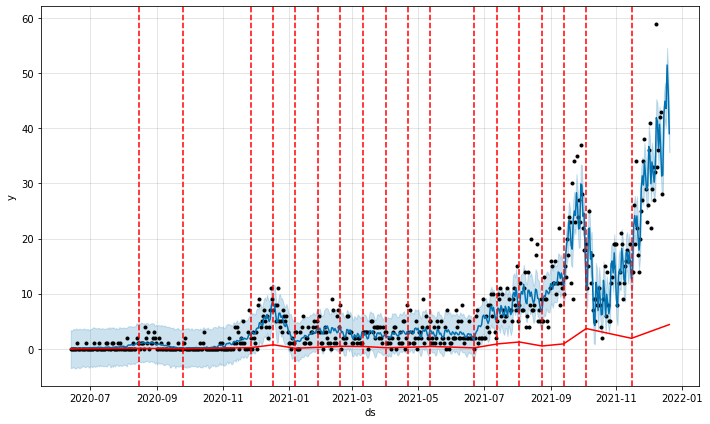

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)